In [1]:
import numpy as np
from radial_constrained_cluster_copy import *
import matplotlib.pyplot as plt
import matplotlib
import random
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon
import xarray as xr
from eofs.multivariate.standard import MultivariateEof
from shapely.geometry import mapping
from sklearn.cluster import KMeans
from scipy import signal
from obspy.signal.tf_misfit import cwt
import pymannkendall as mk
from tqdm import tqdm
from time import sleep

font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 13}

matplotlib.rc('font', **font)

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
region_division = gpd.read_file('~/work/jacopo/DATA/regions/region_division.shp', crs="epsg:4326")
#region_division = world

import dask
dask.config.set(scheduler="synchronous")

from tensorflow.keras import layers, Sequential
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model

2022-09-30 10:49:37.626994: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-30 10:49:37.797070: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/intel/Compiler/11.0/084/lib/intel64:/opt/intel/Compiler/11.0/084/mkl/lib/em64t
2022-09-30 10:49:37.797095: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-09-30 10:49:37.824275: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cu

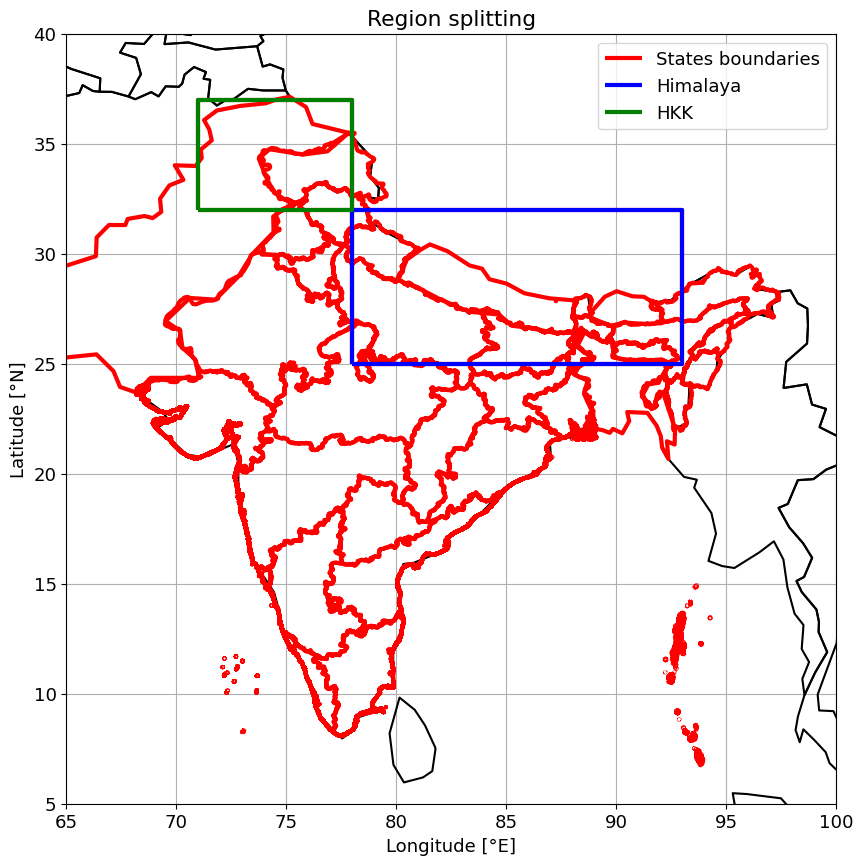

In [2]:
himalaya = Polygon([(78, 25), (93, 25), (93, 32), (78, 32)])
himalaya = gpd.GeoDataFrame({'geometry': [Polygon([(78, 25), (93, 25), (93, 32), (78, 32)])]})
hkk = Polygon([(71, 32), (78, 32), (78, 37), (71, 37)])
hkk = gpd.GeoDataFrame({'geometry': [Polygon([(71, 32), (78, 32), (78, 37), (71, 37)])]})

base = world.boundary.plot(figsize=(10,10), color = 'k')
region_division.boundary.plot(ax = base, color = 'r', linewidth=3, label = 'States boundaries')
himalaya.boundary.plot(ax = base, color = 'b', linewidth=3, label = 'Himalaya')
hkk.boundary.plot(ax = base, color = 'g', linewidth=3, label = 'HKK')

plt.xlim([65, 100])
plt.ylim([5, 40])
plt.grid()
plt.title('Region splitting')
plt.xlabel('Longitude [°E]')
plt.ylabel('Latitude [°N]')
plt.legend()

<Figure size 1000x1000 with 0 Axes>

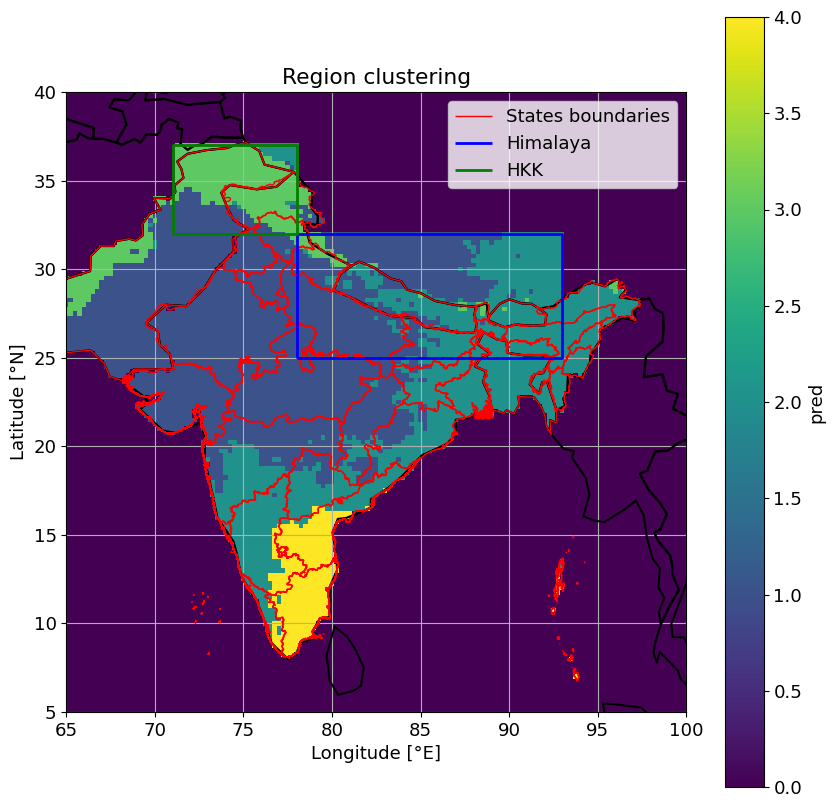

In [3]:
n_eof_comp = 3
n_reg = 5
add_coord = False
add_orog = False
do_detrend = False
orog_w = 0.1
coord_w = 0.25
fields = ['tp']


dataset = xr.open_dataset("~/work/jacopo/DATA/ERA5_prec_day_INDIA.nc").drop("time_bnds").rename(tp = 'tp')*24000
#dataset = dataset.sel(time=slice('1960','1970'))
#dataset = xr.open_dataset("DATA/APHRODITE_1951_2007_daily_INDIA.nc").drop('rstn').fillna(0)

#dataset = xr.open_mfdataset("/archive/paolo/cmip6/CMIP6/model-output/EC-Earth-Consortium/EC-Earth3/historical/atmos/day/r1i1p1f1/pr/*.nc").rename(pr = 'tp').drop(['time_bnds','lat_bnds','lon_bnds'])*24000
#dataset = xr.open_mfdataset("/home/paolo/archive/cmip6/CMIP6/model-output/EC-Earth-Consortium/EC-Earth3/ssp585/atmos/day/r1i1p1f1/pr/*.nc").rename(pr = 'tp').drop(['time_bnds','lat_bnds','lon_bnds'])*24000
#dataset = dataset.sel(lat=slice(5,40), lon=slice(65,100)).sel(time=slice('1980','2010')).load()


if do_detrend == True:
        dataset = detrend(dataset, 'tp', 'time', 1)

dataset_doy = dataset.groupby('time.dayofyear').mean().rename(dayofyear = 'time')

dataset_doy = dataset_doy.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
dataset_doy = dataset_doy.rio.write_crs("epsg:4326", inplace=True)
dataset_doy = dataset_doy.rio.clip(region_division.geometry.apply(mapping), region_division.crs, drop=False)
dataset_doy = dataset_doy.fillna(1)

to_eof = []
for i in fields:
    supp = getattr(dataset_doy,i)
    supp = supp/supp.max('time')
    to_eof.append(supp.to_numpy())
 

to_fit = to_eof

old_shape = np.shape(to_fit)
new_shape = [np.size(to_fit, axis = 0)*np.size(to_fit, axis = 1), np.size(to_fit, axis = 2)*np.size(to_fit, axis = 3)]
to_fit = np.reshape(to_fit, new_shape)

if add_orog == True:
    supp = dataset.orog.mean('time')
    supp = (supp-supp.mean())/supp.std()
    supp = np.squeeze(supp.to_numpy()*orog_w)
    supp = np.transpose(supp.reshape(-1, 1))
    to_fit = np.concatenate((to_fit,supp), axis = 0)

if add_coord == True:
    la, lo = np.meshgrid(dataset.lon.to_numpy(),dataset.lon.to_numpy())
    la = (la-np.mean(la))/np.std(la)
    lo = (lo-np.mean(lo))/np.std(lo)

    supp = np.squeeze(la*coord_w)
    supp = np.transpose(supp.reshape(-1, 1))
    to_fit = np.concatenate((to_fit,supp), axis = 0)

    supp = np.squeeze(lo*coord_w)
    supp = np.transpose(supp.reshape(-1, 1))
    to_fit = np.concatenate((to_fit,supp), axis = 0)


to_fit = np.transpose(to_fit)


model = KMeans(n_clusters=n_reg, max_iter=300, random_state=1).fit(to_fit)
prediction = model.predict(to_fit)
pred = np.reshape(prediction,[old_shape[2], old_shape[3]])
pred =  pred.astype(float)
pred = xr.DataArray(pred).rename('pred').rename(dim_0='lat', dim_1='lon')

dataset = xr.merge([dataset, pred])


plt.figure(figsize = (10,10))

base = world.boundary.plot(figsize=(10,10), color = 'k')
axs = dataset.pred.plot(ax = base)
region_division.boundary.plot(ax = base, color = 'r', linewidth=1, label = 'States boundaries')
himalaya.boundary.plot(ax = base, color = 'b', linewidth=2, label = 'Himalaya')
hkk.boundary.plot(ax = base, color = 'g', linewidth=2, label = 'HKK')

plt.xlim([65, 100])
plt.ylim([5, 40])
plt.title('Region clustering')
plt.xlabel('Longitude [°E]')
plt.ylabel('Latitude [°N]')
plt.legend()
plt.grid()

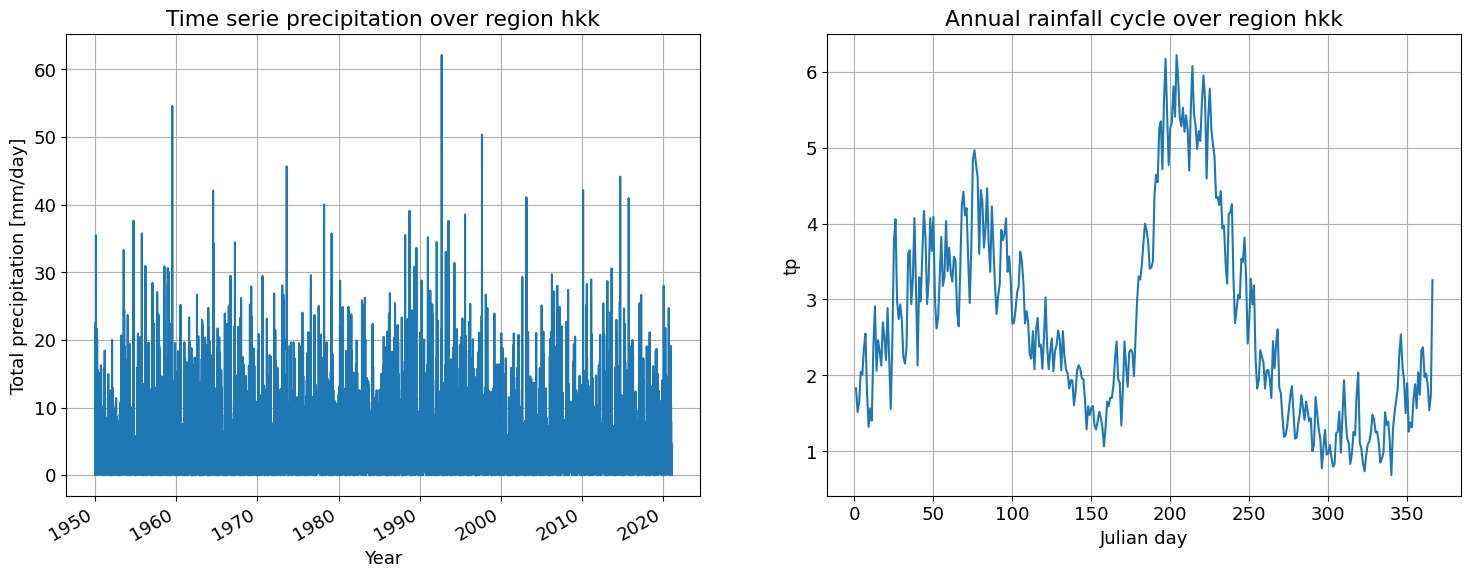

In [4]:
to_see = 'hkk'

if to_see == 'him':
    data = dataset.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
    data = data.rio.write_crs("epsg:4326", inplace=True)
    data = data.rio.clip(himalaya.geometry.apply(mapping), himalaya.crs, drop=False)
    data_doy = data.groupby('time.dayofyear').mean()
    
elif to_see == 'hkk':
    data = dataset.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
    data = data.rio.write_crs("epsg:4326", inplace=True) 
    data = dataset.rio.clip(hkk.geometry.apply(mapping), hkk.crs, drop=False)
    data_doy = data.groupby('time.dayofyear').mean()
    
else:
    data = dataset.where(dataset.pred == to_see)
    data_doy = dataset_doy.where(dataset.pred == to_see)
    
    
fig, axs = plt.subplots(1,2, figsize = (18,6), sharey = False)
data.tp.mean(['lat','lon']).plot(ax=axs[0])
axs[0].set_title(f'Time serie precipitation over region {to_see}')
axs[0].grid()
axs[0].set_ylabel('Total precipitation [mm/day]')
axs[0].set_xlabel('Year')

data_doy.tp.mean(['lat','lon']).plot(ax=axs[1])
axs[1].set_title(f'Annual rainfall cycle over region {to_see}')
axs[1].set_xlabel('Julian day')
axs[1].grid()

In [5]:
data_do = data_doy.fillna(1000)

to_enc = data_do.tp.to_numpy()

to_enc = to_enc - np.nanmean(to_enc,axis = 0 )
#to_enc = to_enc / np.nanstd(to_enc,axis = 0 )

np.shape(to_enc)

(366, 141, 141)

In [49]:
# Encoder
encoder = Sequential([
    layers.Conv2D(32, (3, 3), activation="relu", padding="same"),
    layers.MaxPooling2D((2, 2), padding="same"),
    layers.Conv2D(32, (3, 3), activation="relu", padding="valid"),
    layers.MaxPooling2D((2, 2), padding="same"),
])

# Decoder
decoder = Sequential([
    layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same"),
    layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="valid"),
    layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same"),
])


# Autoencoder
input = layers.Input(shape=(141, 141, 1))
latent_vector = encoder(input)
output = decoder(latent_vector)
autoencoder = Model(inputs = input, outputs = output)
autoencoder.compile("adam", loss = "binary_crossentropy")
#autoencoder.summary()
#print(encoder.summary())
print(decoder.summary())

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose_26 (Conv2D  (None, 70, 70, 32)       9248      
 Transpose)                                                      
                                                                 
 conv2d_transpose_27 (Conv2D  (None, 141, 141, 32)     9248      
 Transpose)                                                      
                                                                 
 conv2d_50 (Conv2D)          (None, 141, 141, 1)       289       
                                                                 
Total params: 18,785
Trainable params: 18,785
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/10
3/3 [==============================] - 6s 2s/step - loss: 0.6895
Epoch 2/10
3/3 [==============================] - 6s 2s/step - loss: 0.6781
Epoch 3/10
3/3 [==============================] - 6s 2s/step - loss: 0.6603
Epoch 4/10
3/3 [==============================] - 6s 2s/step - loss: 0.6265
Epoch 5/10
3/3 [==============================] - 6s 2s/step - loss: 0.5682
Epoch 6/10
3/3 [==============================] - 6s 2s/step - loss: 0.4905
Epoch 7/10
3/3 [==============================] - 6s 2s/step - loss: 0.4118
Epoch 8/10
3/3 [==============================] - 6s 2s/step - loss: 0.3269
Epoch 9/10
3/3 [==============================] - 6s 2s/step - loss: 0.1973
Epoch 10/10
3/3 [==============================] - 6s 2s/step - loss: 0.0075


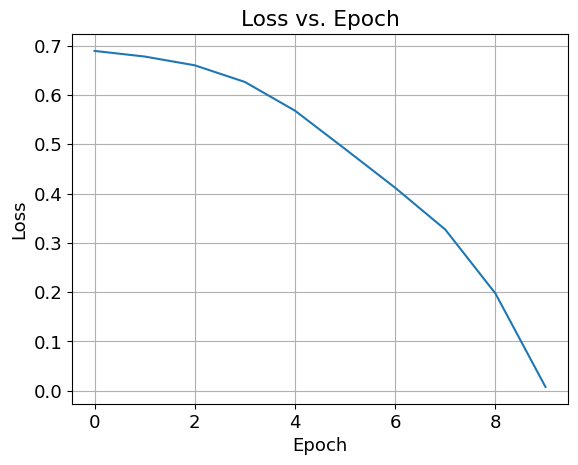

In [50]:
model_history = autoencoder.fit(
    x=to_enc,
    y=to_enc,
    epochs=10,
    batch_size=128,
    shuffle=True,
)

plt.plot(model_history.history["loss"])
plt.title("Loss vs. Epoch")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.grid(True)

In [54]:
predictions = autoencoder.predict(to_enc[0:10,:,:])

1/1 [==============================] - 0s 57ms/step


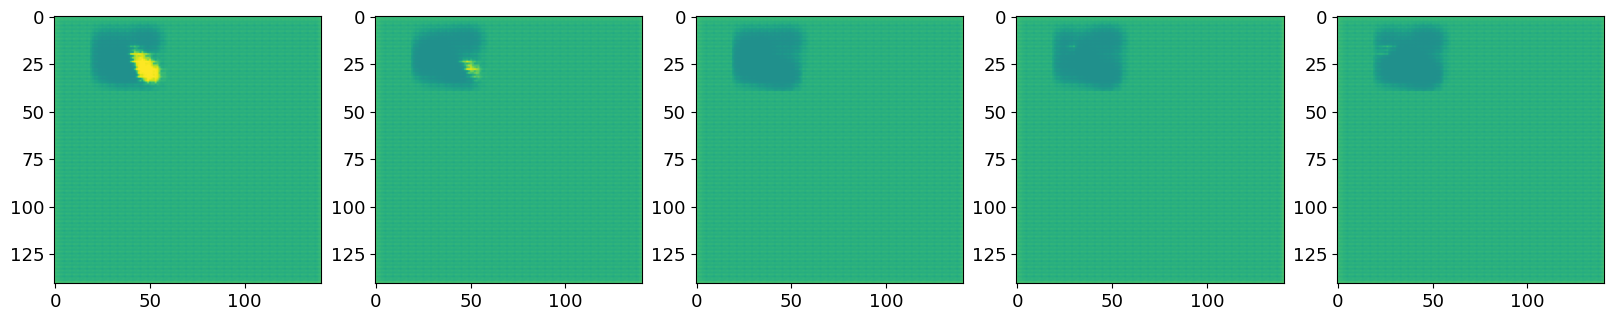

In [55]:
fig, axs = plt.subplots(1,5, figsize=(20,8))
for i in range(5):
    axs[i].imshow(np.squeeze(predictions[i,:,:]), vmin=-1, vmax=1)

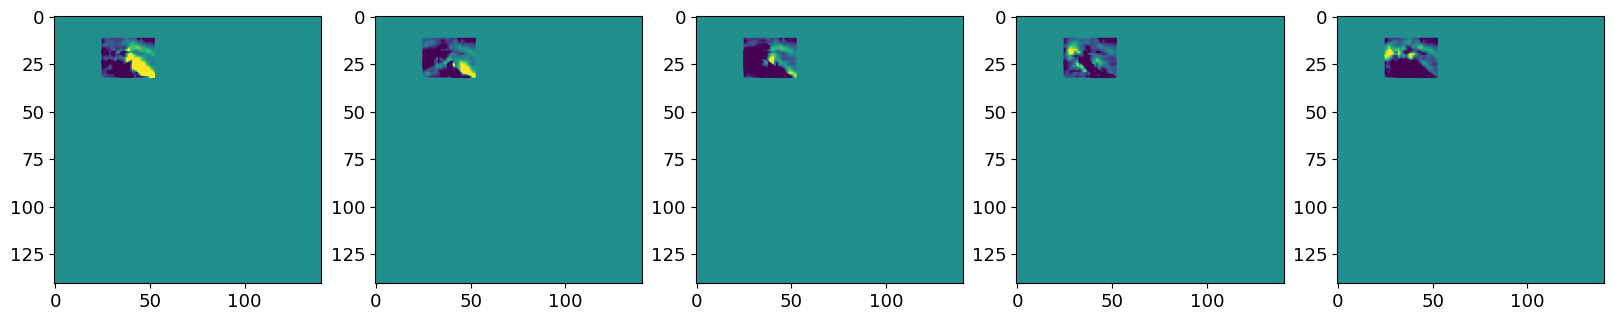

In [56]:
fig, axs = plt.subplots(1,5, figsize=(20,8))
for i in range(5):
    axs[i].imshow(np.squeeze(to_enc[i,:,:]), vmin=-1, vmax=1)

In [57]:
encoded_x_train = encoder(to_enc)

In [58]:
#fig, axs = plt.subplots(1,5, figsize=(20,8))
#for i in range(5):
#    axs[i].imshow(np.squeeze(encoded_x_train[i,:,:,0]))


#fig, axs = plt.subplots(1,5, figsize=(20,8))
#for i in range(5):
#    axs[i].imshow(np.squeeze(encoded_x_train[i,:,:,1]))

#fig, axs = plt.subplots(1,5, figsize=(20,8))
#for i in range(5):
#    axs[i].imshow(np.squeeze(encoded_x_train[i,:,:,2]))

In [59]:
to_cluster = np.reshape(encoded_x_train, (np.size(encoded_x_train, axis= 0),np.size(encoded_x_train, axis= 1)*np.size(encoded_x_train, axis= 2)*np.size(encoded_x_train, axis= 3)))

In [60]:
np.shape(to_cluster)

(366, 39200)

Text(0, 0.5, 'Within-Cluster Sum of Square')

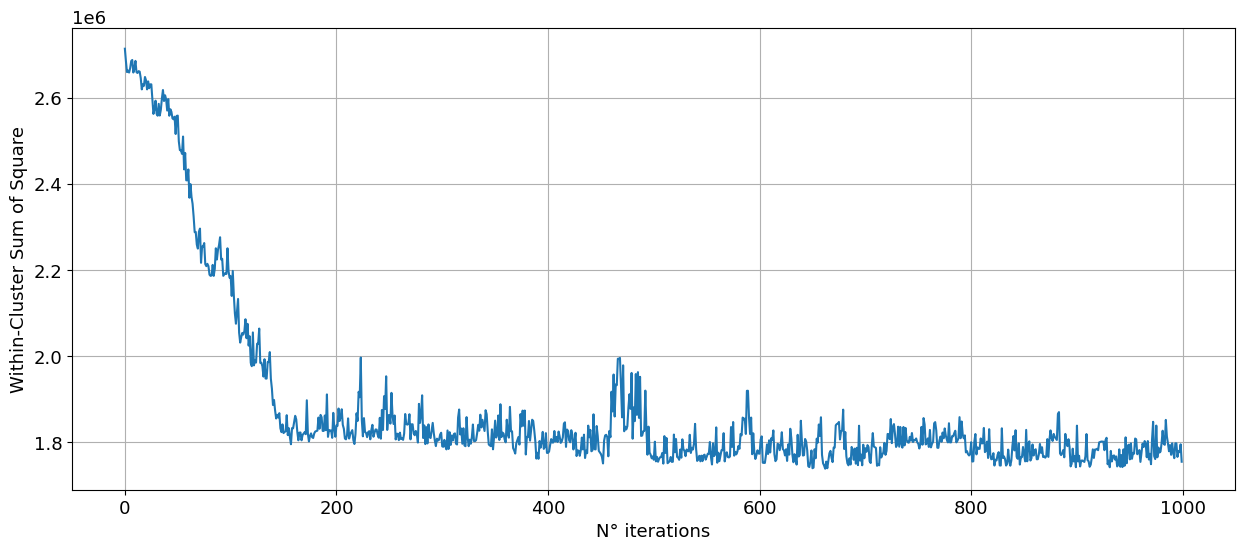

In [61]:
n_seas = 4

model = Radially_Constrained_Cluster(to_cluster, n_seas)

model.fit()
prediction = model.get_prediction()


plt.figure(figsize = (15,6))
plt.plot(model.error_story)
plt.grid()
plt.xlabel('N° iterations')
plt.ylabel('Within-Cluster Sum of Square')

Text(0, 0.5, 'Tp [mm/day]')

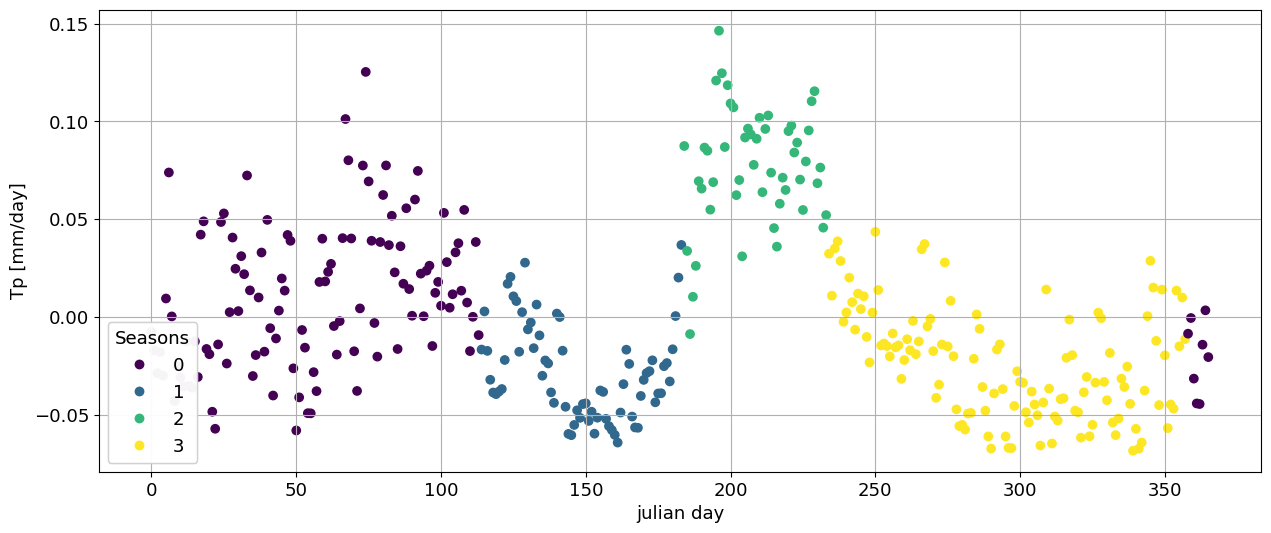

In [62]:
fig, ax = plt.subplots(figsize = (15,6))
scatter = ax.scatter(range(np.size(to_cluster, axis=0)), to_enc.mean(axis = (1,2)), c = prediction)
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Seasons")
ax.add_artist(legend1)
ax.grid()
ax.set_xlabel('julian day')
ax.set_ylabel('Tp [mm/day]')

In [63]:
for i in range(np.size(to_cluster,axis=1)):
    plt.plot(to_cluster[:,i])


Error in callback <function flush_figures at 0x7fdd169ab760> (for post_execute):


KeyboardInterrupt: 

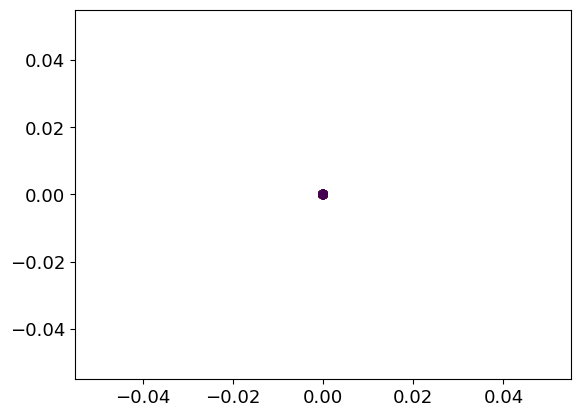

In [ ]:
plt.scatter(to_cluster[:,0],to_cluster[:,1], c= prediction)

In [ ]:
year =  np.unique(data.time['time.year'].to_numpy())
n_year = len(np.unique(data.time['time.year'].to_numpy()))

serie = data.tp.mean(['lat','lon']).to_numpy()
time = pd.DatetimeIndex(data.time.to_numpy())
line_time = pd.Series(serie, index=time)

#breakpoints = np.sort(model.breakpoints)

season_mean = np.empty((n_seas,n_year))
season_mean[:] = np.nan 

periods = np.arange(year[0],year[-2],1)
step = 15

b_p = []
t_p = []

for i in tqdm(np.arange(0,len(periods)-step,1)):
    sleep(3)
    to_analyze = data.sel(time = slice(str(periods[i]),str(periods[i+step])))
    to_analyze = to_analyze.groupby('time.dayofyear').mean()
    to_ana = to_analyze.fillna(100)

    to_enc = to_ana.tp.to_numpy()

    to_enc = to_enc - np.nanmean(to_enc,axis = 0 )

    encoded_x_train = encoder(to_enc)

    to_cluster = np.reshape(encoded_x_train, (np.size(encoded_x_train, axis= 0),np.size(encoded_x_train, axis= 1)*np.size(encoded_x_train, axis= 2)*np.size(encoded_x_train, axis= 3)))

    model = Radially_Constrained_Cluster(to_cluster, n_seas)
    model.fit()
    prediction = model.get_prediction()
    prediction = np.squeeze(np.int32(prediction))

    b_p.append(model.breakpoints)

    season_mean = np.empty((n_seas,1))
    season_mean[:] = np.nan
    tr = to_analyze.tp.mean(['lon','lat']).to_numpy()

    
    for j in range(n_seas):
             
        gr = tr[prediction == j]
        season_mean[j] = np.mean(gr)
        
    t_p.append(season_mean)


b_p = np.array(b_p)
b_p = np.transpose(b_p)

t_p = np.array(t_p)
t_p = np.squeeze(t_p)
t_p = np.transpose(t_p)

  0%|          | 0/54 [00:09<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
colors = ['red','blue','green','purple']

plt.figure(figsize=(15,7))

print()
print('BREAKPOINTS TRENDS')

for i in range(n_seas):
    x = periods[0:-step]
    y = b_p[i]
    
    idx = np.isfinite(x) & np.isfinite(y)
    ab = np.polyfit(x[idx], y[idx], 1)
    
    if i == n_seas-1:
        
        plt.plot(x, ab[1]+x*ab[0], c = colors[0])
        plt.plot(periods[0:-step],b_p[i], '-.*', label = f'season {0}', c = colors[0], markersize = 15)
        result = mk.original_test(b_p[i])
        print(f'Season {0}')
        print(f'Linear trend: {ab[0]}')
        print(f'Mann Kendall trend: {result.slope} - {result.h} - {result.p}')
        
    else:
    
        plt.plot(x, ab[1]+x*ab[0], c = colors[i+1])
        plt.plot(periods[0:-step],b_p[i], '-.*', label = f'season {i+1}', c = colors[i+1], markersize = 15)
        result = mk.original_test(b_p[i])
        print(f'Season {i+1}')
        print(f'Linear trend: {ab[0]}')
        print(f'Mann Kendall trend: {result.slope} - {result.h} - {result.p}')
    
plt.xlabel('year')
plt.yticks([0,30,59,90,120,151,181,212,243,273,304,335,366],
            ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec','Jan'])
plt.ylabel('season breakpoint [julian day]')
plt.grid()
plt.legend()
plt.title('Breakpoints evolution')

plt.figure(figsize=(15,7))

print()

print('TOTAL PRECIPITATIONS TRENDS')

for i in range(n_seas):
    x = periods[0:-step]
    y = t_p[i]
    
    idx = np.isfinite(x) & np.isfinite(y)
    ab = np.polyfit(x[idx], y[idx], 1)
    

    plt.plot(x, ab[1]+x*ab[0], c = colors[i])
    plt.plot(periods[0:-step],t_p[i], '-.*', label = f'season {i}', c = colors[i], markersize = 15)
    result = mk.original_test(t_p[i])
    print(f'Season {i+1}')
    print(f'Linear trend: {ab[0]}')
    print(f'Mann Kendall trend: {result.slope} - {result.h} - {result.p}')
    
plt.xlabel('year')
plt.ylabel('t_p[mm/day]')
plt.grid()
plt.legend()
plt.title('Total precipitation evolution')